In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, v2, CenterCrop

class AgeDataset(Dataset):
    def __init__(self, root='/kaggle/input/huhuhu1/age/', train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = ['20-30s', '40-50s', 'baby', 'kid', 'senior', 'teenager']
        self.transform = transform
        
        if train:
            data_path = os.path.join(root, 'train')
        else:
            data_path = os.path.join(root, 'valid')
        
        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path,category)
            for item in os.listdir(data_files):
                path = os.path.join(data_files,item)
                self.image_paths.append(path)
                self.labels.append(i)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
import os
os.listdir('/kaggle/input/huhuhu1/age/train')

['40-50s', 'senior', 'teenager', 'baby', 'kid', '20-30s']

In [3]:
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 
root = '/kaggle/input/huhuhu1/age/'
train_dataset = AgeDataset(root=root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = AgeDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# for images, labels in train_loader:
#     print(images.shape, labels.shape)
# for images, labels in test_loader:
#     print(images.shape, labels.shape)

27783
3058


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch
import torch.nn as nn

class MyEffnet(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()
        self.backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        self.backbone.classifier[1] = nn.Linear(1280, n_classes)
    
    def forward(self, x):
        x = self.backbone(x)
        return x

In [12]:
# from torchvision.models import resnet50, ResNet50_Weights, efficientnet_v2_s, EfficientNet_V2_S_Weights
# import torch.nn as nn
# import torch
# m = efficientnet_v2_s()
# m.classifier[1] = nn.Linear(1280, 2)
# x = torch.randn(16, 3, 224, 224)
# print(m(x).shape)

In [13]:
x = torch.randn(16, 3, 224, 224)
model = MyEffnet()
# print(model)
print(model(x).shape)

torch.Size([16, 6])


In [14]:
import torch.optim as optim
from tqdm import tqdm
epochs = 40
batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)#optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_workers = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

In [15]:
train_dataset = AgeDataset(root= root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = AgeDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

27783
3058


In [25]:
model = MyEffnet().to(device)
if os.path.exists('last.pt'):
    if torch.cuda.is_available():
        model.load_state_dict(torch.load('last.pt'))
    else:
        model.load_state_dict(torch.load('last.pt', map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5) 

In [26]:
best_acc = 0
best_model = MyEffnet().to(device)
if os.path.exists('best.pt'):
    best_model.load_state_dict(torch.load('best.pt',map_location=torch.device('cpu')))
    best_model.eval()
    all_predictions_best = []
    all_labels_best = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions_best.extend(predictions)
            all_labels_best.extend(labels.cpu())     
    all_labels_best = [label.item() for label in all_labels_best]
    all_predictions_best = [prediction.item() for prediction in all_predictions_best]
    best_acc = accuracy_score(all_labels_best, all_predictions_best)

In [27]:
epochs=20
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    torch.save(model.state_dict(), 'last.pt')
    if acc > best_acc:
        torch.save(model.state_dict(), 'best.pt')
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

Epoch: 1/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:01<00:00,  9.61it/s]


Epoch: 1/20 Test Loss: 0.0539 Test Acc: 0.8506


Epoch: 2/20 Iter: 3473 Loss: 0.0001: 100%|██████████| 3473/3473 [06:01<00:00,  9.61it/s]


Epoch: 2/20 Test Loss: 0.0338 Test Acc: 0.8502


Epoch: 3/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:01<00:00,  9.61it/s]


Epoch: 3/20 Test Loss: 0.0333 Test Acc: 0.8476


Epoch: 4/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:01<00:00,  9.61it/s]


Epoch: 4/20 Test Loss: 0.0715 Test Acc: 0.8525


Epoch: 5/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:02<00:00,  9.59it/s]


Epoch: 5/20 Test Loss: 0.0416 Test Acc: 0.8486


Epoch: 6/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:00<00:00,  9.62it/s]


Epoch: 6/20 Test Loss: 0.0679 Test Acc: 0.8499


Epoch: 7/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:00<00:00,  9.65it/s]


Epoch: 7/20 Test Loss: 0.1244 Test Acc: 0.8496


Epoch: 8/20 Iter: 3473 Loss: 0.0003: 100%|██████████| 3473/3473 [06:00<00:00,  9.63it/s]


Epoch: 8/20 Test Loss: 0.0707 Test Acc: 0.8479


Epoch: 9/20 Iter: 3473 Loss: 0.0009: 100%|██████████| 3473/3473 [06:00<00:00,  9.64it/s]


Epoch: 9/20 Test Loss: 0.0772 Test Acc: 0.8506


Epoch: 10/20 Iter: 3473 Loss: 0.0199: 100%|██████████| 3473/3473 [06:00<00:00,  9.62it/s]


Epoch: 10/20 Test Loss: 0.1017 Test Acc: 0.8506


Epoch: 11/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:00<00:00,  9.62it/s]


Epoch: 11/20 Test Loss: 0.0561 Test Acc: 0.8532


Epoch: 12/20 Iter: 3473 Loss: 0.0001: 100%|██████████| 3473/3473 [06:00<00:00,  9.63it/s]


Epoch: 12/20 Test Loss: 0.1098 Test Acc: 0.8512


Epoch: 13/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:00<00:00,  9.63it/s]


Epoch: 13/20 Test Loss: 0.1362 Test Acc: 0.8509


Epoch: 14/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [05:59<00:00,  9.65it/s]


Epoch: 14/20 Test Loss: 0.1010 Test Acc: 0.8525


Epoch: 15/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:01<00:00,  9.61it/s]


Epoch: 15/20 Test Loss: 0.1402 Test Acc: 0.8522


Epoch: 16/20 Iter: 2334 Loss: 0.0008:  67%|██████▋   | 2333/3473 [04:03<01:58,  9.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 17/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:02<00:00,  9.57it/s]


Epoch: 17/20 Test Loss: 0.0773 Test Acc: 0.8545


Epoch: 18/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:04<00:00,  9.53it/s]


Epoch: 18/20 Test Loss: 0.1211 Test Acc: 0.8532


Epoch: 19/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:04<00:00,  9.54it/s]


Epoch: 19/20 Test Loss: 0.0317 Test Acc: 0.8506


Epoch: 20/20 Iter: 3473 Loss: 0.0000: 100%|██████████| 3473/3473 [06:05<00:00,  9.52it/s]


Epoch: 20/20 Test Loss: 0.0162 Test Acc: 0.8509


In [28]:
test_model = MyEffnet().to(device)
test_model.load_state_dict(torch.load('best.pt', map_location=torch.device('cpu')))
test_model.eval()

MyEffnet(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24

In [33]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = ['20-30s', '40-50s', 'baby', 'kid', 'senior', 'teenager']
indices = random.sample(range(0, test_dataset.__len__()), 8)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]
predictions = torch.argmax(test_model(images.to(device)).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[2760, 257, 91, 1748, 2144, 2546, 1620, 1607]
torch.Size([8, 3, 224, 224])
[3, 0, 0, 0, 0, 1, 0, 0]
tensor([3, 0, 0, 0, 0, 0, 0, 0])


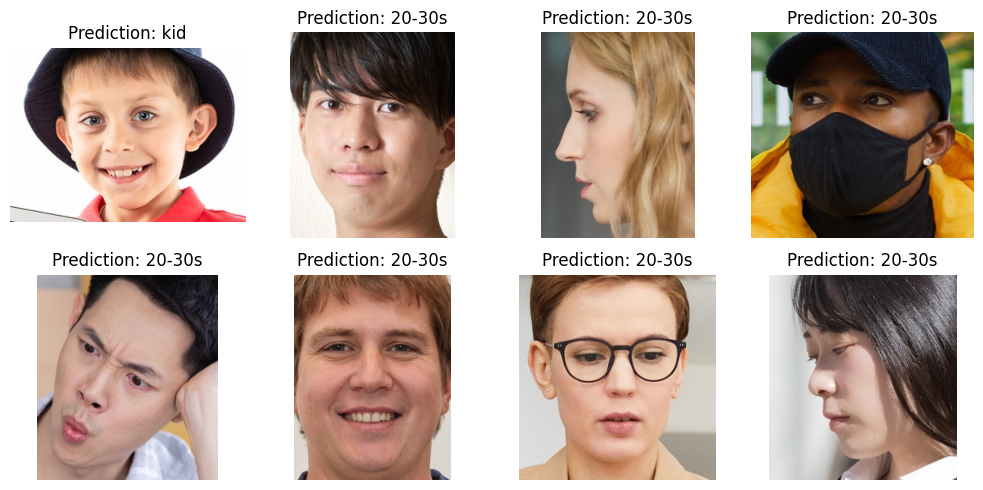

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()